# Explore Exploit Dilemma
[Lecture 12-15](https://www.udemy.com/recommender-systems/learn/lecture/11700414) covered the topic of ranking using a Bayesian approach.

Here, ranking is the problem of arranging items when their usefulness is unkown. 
For example, consider ranking products before they have received any reviews, or news articles befor they have received many clicks.

In the course, a useful toy example was presented.
Consider approaching a line of 3 slot machines. 
Spinning a machine results in either a win or a loss, i.e. a binary outcome, and all three machines cost the same.
However, the machines have different win rates $p(win)$. 
Of course, we would like to spin the machine with the highest win rate.

The explore-exploit dilemma is that we would like to collect data on the win rates of the three machines, but also exploit our knowledge of what machine is the most lucrative.
Without playing all machines we cannot be certain that one of them has a higher win rate than the others, but collecting data on all machines requires us to spend money on playing the less lucrative machines.

## The Bayesian Approach
The Bayesian approach to the explore exploit dilemma is to continously update probability distributions for the belief about the win rates of the slot machines (posteriors). 
Since the machines have a binary outcome, we represent their outcome as a Bernouli distribution:
$p(x) = \pi^{x} (1-\pi)^{1-x}$, and choose an apriori belief about $\pi$, which we will update through exploration.
Choosing $\pi \sim B(\alpha, \beta)$ is useful because the Beta distribution is a so called conjugate prior of the Bernoulli distribution, meaning that updating the prior using Bayes rule results in a posterior that is still Beta distributed.

By spinning a slot machine, we sample new values of $x$, which can be used to update our belief about the win rate of the slot machine.
With the Beta distribution this is as simple as setting $\alpha´ = \alpha + x, \beta´ = \beta + 1 - x$.

Thanks to the probability distibutions over the slot machines winrates, we get access to a neat way of solving the explore-exploit dilemma.
Any time we want to play a slot machine we sample a win rate from the belief we carry about each machine, and choose to spin the machine with the highest probability.
Before we are certain about the machines win rates we will spin all of them frequently, but once the distributions sharpen due to enough samples, we will start favoring machines with higher win rates.

In this notebook I draw inspiration from the code lecture and implement the bayesian approach to the toy example.

# Code

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
class Machine:
    def __init__(self, true_winrate):
        self.p = true_winrate
        # Alpha and Beta
        self.a = 1
        self.b = 1
        
    def spin(self):
        # Spin the machine, win at the true win rate
        return np.random.random() < self.p
    
    def sample(self):
        # Sample for our belief about the machine
        return np.random.beta(self.a, self.b)
    
    def update(self):
        x = self.spin()
        self.a += x
        self.b += 1 - x

In [3]:
def draw_posteriors(machines, spins, ax):
    x = np.linspace(0, 1, 200)
    for machine in machines:
        y = beta.pdf(x, machine.a, machine.b)
        ax.plot(x, y)
    ax.set_title("%d spins" % spins)
        

In [14]:
true_winrates = [0.1, 0.3, 0.5, 0.55, 0.6]
machines = [Machine(p) for p in true_winrates]

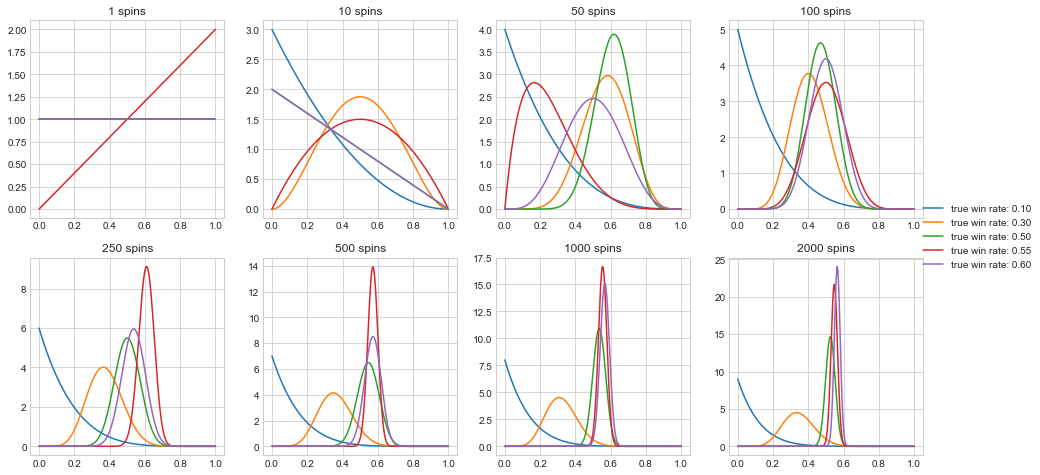

In [15]:
f, ax = plt.subplots(2, 4, figsize=(16,8))
ax = ax.flatten()
sample_points = [1, 10, 50, 100, 250, 500, 1000, 2000]
i = 0

for spin in range(2001):
    if spin in sample_points:
        draw_posteriors(machines, spin, ax[i])
        i += 1
    samples = [machine.sample() for machine in machines]
    best_idx = np.argmax(samples)
    machines[best_idx].update()
    
f.legend(["true win rate: %.2f" % machine.p for machine in machines],  loc = 'center right')

Cool! The algorithm quickly figures out that it should stop spinning the machines with $0.10$ and $0.30$ win rates. However, after 250 spins it is still underd the false impression that the machine with a win rate of $0.55$ is the best, and it is not until after 1000 spins that the true winner has the most favorable distribution. However, even after 2000 spins the distributions for the three best machines overlap partly, so some spins will still be made on inferior machines, but much fewer than at the start of the experiment.